# Logistic regression with PyMC3

Logistic regression allows the analysis of how a set of features affects a binary target label. Posterior distribution over the weights provides an estimation of the influence of each feature on the probability of the target being equal to one.    

Posterior distribution also provides the interval estimates for each weight of the model, which is important for data analysis when estimates of the uncertainty of conclusions are required in addition to a good model.

The PyMC3 library will be used to perform approximate Bayesian inference for logistic regression. This is based on the logistic regression tutorial by Peadar Coyle and J. Benjamin Cook, and completed as part of the Advanced Machine Learning specialisation on Coursera.

Data used here is the [UCI Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult). The problem is to model how the probability that a person has salary $\geq$ \\$50K is affected by his/her age, education, sex and other features.

Let $y_i = 1$ if i-th person's salary is $\geq$ \\$50K and $y_i = 0$ otherwise. Let $x_{ij}$ be $j$-th feature of $i$-th person.

Logistic regression models this probabilty in the following way:

$$p(y_i = 1 \mid \beta) = \sigma (\beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_k x_{ik} ), $$

where $\sigma(t) = \frac1{1 + e^{-t}}$


### Question

The particular question of interest here is: does the gender of a person affects his or her salary? For this, the concept of *odds* will be used.

If there is a binary random variable $y$ (which may indicate whether a person makes \\$50K) and if the probabilty of the positive outcome $p(y = 1)$ is for example 0.8, we will say that the *odds* are 4 to 1 (or just 4), as succeeding is 4 times more likely than failing $\frac{p(y = 1)}{p(y = 0)} = \frac{0.8}{0.2} = 4$.

Returning to the effect of gender on the salary. The **ratio** between the odds of a male having salary $\geq $ \\$50K and the odds of a female (with the same level of education, experience and everything else) having salary $\geq$ \\$50K can be computed. The first feature of each person in the dataset is gender. Specifically, $x_{i1} = 0$ if the person is female and $x_{i1} = 1$ otherwise. Consider two people $i$ and $j$ having all but one feature the same with the only difference in $x_{i1} \neq x_{j1}$.

If the logistic regression model above estimates the probabilities exactly, the odds for a male will be:
$$
\frac{p(y_i = 1 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})}{p(y_i = 0 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})} = \frac{\sigma(\beta_1 + \beta_2 x_{i2} + \ldots)}{1 - \sigma(\beta_1 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1 + \beta_2 x_{i2} + \ldots)
$$

The ratio of the male and female odds will be:
$$
\frac{\exp(\beta_1 \cdot 1 + \beta_2 x_{i2} + \ldots)}{\exp(\beta_1 \cdot 0 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1)
$$

So given the correct logistic regression model, we can estimate odds ratio for some feature (gender here) by just looking at the corresponding coefficient. But, even if all the logistic regression assumptions are met, the coefficient cannot be estimated exactly from real-world data, it is too noisy. So an interval estimate can be built, which would provide information along the lines of "with probability 0.95 the odds ratio is greater than 0.8 and less than 1.2, so we cannot conclude that there is any gender discrimination in the salaries" (or vice versa, that "with probability 0.95 the odds ratio is greater than 1.5 and less than 1.9 and discrimination takes place because a male has at least 1.5 higher probability to get >$50k than a female with the same level of education, age, etc."). In Bayesian statistics, this interval estimate is called *credible interval*.

It is impossible to compute this credible interval analytically. So MCMC is used for this.

#### Credible interval
A credible interval for the value of $\exp(\beta_1)$ is an interval $[a, b]$ such that $p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}})$ is $0.95$ (or some other predefined value). To compute the interval, the posterior distribution $p(\exp(\beta_1) \mid X_{\text{train}}, y_{\text{train}})$ needs to be accessed.

For simplicity, the focus will be on the posterior of the parameters $p(\beta_1 \mid X_{\text{train}}, y_{\text{train}})$ since if this is computed, $[a, b]$ can always be found, such that $p(\log a \leq \beta_1 \leq \log b \mid X_{\text{train}}, y_{\text{train}}) = p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}}) = 0.95$


### Loading the data

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("adult.data", header=None, delimiter=r",",)
data.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
data.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data = data[['Gender','Age','EducationNum','HoursPerWeek','Income']]

In [4]:
data.isnull().values.any()

False

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Gender        32561 non-null  object
 1   Age           32561 non-null  int64 
 2   EducationNum  32561 non-null  int64 
 3   HoursPerWeek  32561 non-null  int64 
 4   Income        32561 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [6]:
data.Income.unique()

array([' <=50K', ' >50K'], dtype=object)

In [7]:
data["Income"] = data["Income"].map({ " <=50K": 0, " >50K": 1 })

In [8]:
data.head()

,Gender,Age,EducationNum,HoursPerWeek,Income
0,Male,39,13,40,0
1,Male,50,13,13,0
2,Male,38,9,40,0
3,Male,53,7,40,0
4,Female,28,13,40,0


### MAP inference

Each row of the dataset is a person with his or her features. The last column is the target variable $y$. 1 indicates that this person's annual salary is >$50K.

Firstly, a Bayesian logistic regression model needs to be set up (i.e. define priors on the parameters $\alpha$ and $\beta$ of the model) that predicts the value of income >$50K based on a person's age and education:

$$
p(y = 1 \mid \alpha, \beta_1, \beta_2) = \sigma(\alpha + \beta_1 x_1 + \beta_2 x_2) \\ 
\alpha \sim N(0, 100^2) \\
\beta_1 \sim N(0, 100^2) \\
\beta_2 \sim N(0, 100^2), \\
$$

where $x_1$ is a person's age, $x_2$ is his/her level of education, y indicates his/her level of income, $\alpha$, $\beta_1$ and $\beta_2$ are paramters of the model.

In [9]:
with pm.Model() as manual_logistic_model:
    #declare pymc random variables for logistic regression coefficients with uninformative 
    #prior distributions N(0, 100^2) on each weight using pm.Normal
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_age_coefficient = pm.Normal('beta_age_coefficient', mu=0, sd=100)
    beta_education_coefficient = pm.Normal('beta_education_coefficient', mu=0, sd=100)   
    
    #transform these random variables into vector of probabilities p(y_i=1) using logistic regression model specified 
    #above. PyMC random variables are theano shared variables and support simple mathematical operations.
    z = alpha + beta_age_coefficient*np.array(data['Age']) + beta_education_coefficient*np.array(data['EducationNum'])
    a = pm.invlogit(z)    
    
    #declare PyMC Bernoulli random vector with probability of success equal to the corresponding value
    #given by the sigmoid function.
    y_obs = pm.Bernoulli('y_obs', p=a, observed=data['Income'])    
    
    #use pm.find_MAP() to find maximum a-posteriori estimate for the vector of logistic regression weights.
    map_estimate = pm.find_MAP()
    print(map_estimate)

logp = -18,844, ||grad|| = 57,293: 100%|██████████| 30/30 [00:00<00:00, 271.82it/s]   


{'alpha': array(-6.74811904), 'beta_age_coefficient': array(0.04348316), 'beta_education_coefficient': array(0.36210803)}


In [10]:
with pm.Model() as logistic_model:
    #simpler interface for generalised linear models in pymc3 using from_formula    
    pm.glm.GLM.from_formula('Income ~ Age + EducationNum', data, family=pm.glm.families.Binomial())    
    
    map_estimate = pm.find_MAP()
    print(map_estimate)

logp = -15,131, ||grad|| = 0.024014: 100%|██████████| 32/32 [00:00<00:00, 325.73it/s]    

{'Intercept': array(-6.7480998), 'Age': array(0.04348259), 'EducationNum': array(0.36210894)}


### MCMC inference to find credible regions

#### Metropolis-Hastings
The Metropolis-Hastings algorithm will first be used for finding the samples from the posterior distribution.

The hyperparameters of Metropolis-Hastings, such as the proposal distribution variance, can then be explored to speed up the convergence. The `plot_traces` function can be used to visually inspect the convergence.

MAP-estimate can also be used to initialise the sampling scheme to speed things up. This will make the warmup (burn-in) period shorter since starting from a probable point.

In [11]:
import arviz as az

#function to visualise the sampling process, plot traces overlaid with means and values
def plot_traces(traces, burnin=2000):
    ax = pm.traceplot(traces[burnin:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in az.summary(traces[burnin:]).iterrows()})

    for i, mn in enumerate(az.summary(traces[burnin:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

In [12]:
#unlikely dependency between age and salary is linear, so age squared added in as a feature
#to model dependency that favours certain ages
data['agesq'] = data['Age'] ** 2
data.head()

,Gender,Age,EducationNum,HoursPerWeek,Income,agesq
0,Male,39,13,40,0,1521
1,Male,50,13,13,0,2500
2,Male,38,9,40,0,1444
3,Male,53,7,40,0,2809
4,Female,28,13,40,0,784


In [13]:
#logistic regression model trained on features
with pm.Model() as logistic_model:
    
    pm.glm.GLM.from_formula('Income ~ Gender + Age + agesq + EducationNum + HoursPerWeek', data, family=pm.glm.families.Binomial())
    with logistic_model:
        #pm.sample used to run MCMC to train the model
        #pm.Mretropolis specifies Metropolis-Hastings sampler method
        #trained model for 400 samples
        #output saved to trace - used to estimate stats of posterior distribution
        trace = pm.sample(400, step=pm.Metropolis(), progressbar=False, njobs=-1)

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [HoursPerWeek]
>Metropolis: [EducationNum]
>Metropolis: [agesq]
>Metropolis: [Age]
>Metropolis: [Gender[T. Male]]
>Metropolis: [Intercept]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


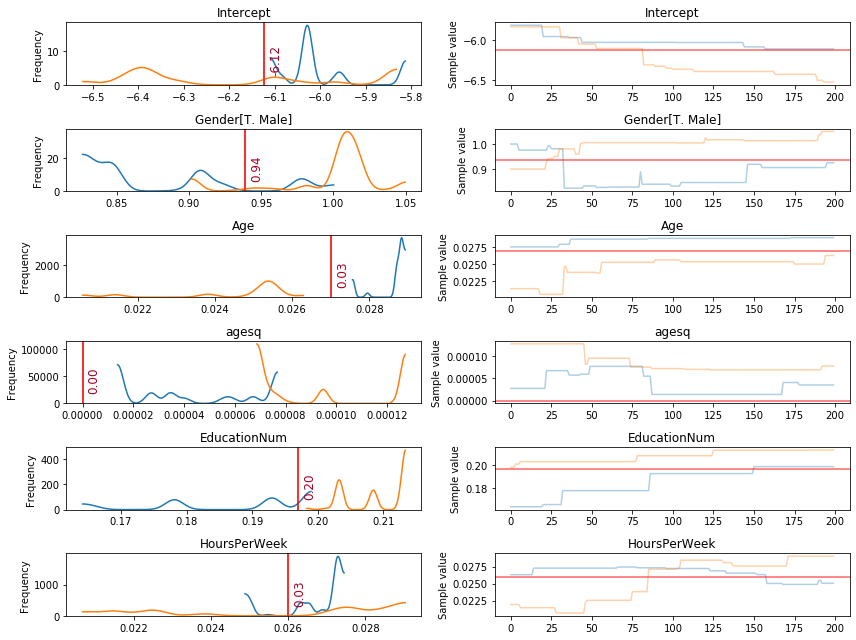

In [14]:
plot_traces(trace, burnin=200)

#### NUTS sampler
Here, pm.sample will be used without specifying a particular sampling method, and so pymc3 will choose it automatically.    

The sampling algorithm that will be used in this case is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameters are tuned automatically. This usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

In [15]:
with pm.Model() as logistic_model:
    #train Bayesian logistic regression model on the following features: sex, age, age_squared, educ, hours
    #use pm.sample to run MCMC to train this model.
    #train model for 400 samples.
    
    pm.glm.GLM.from_formula('Income ~ Gender + Age + agesq + EducationNum + HoursPerWeek', data, family=pm.glm.families.Binomial())
    with logistic_model:
        trace = pm.sample(4000, step=pm.NUTS(), progressbar=False, njobs=-1)    

Sequential sampling (2 chains in 1 job)
NUTS: [HoursPerWeek, EducationNum, agesq, Age, Gender[T. Male], Intercept]
The acceptance probability does not match the target. It is 0.9880156216297372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9661312159635906, but should be close to 0.8. Try to increase the number of tuning steps.


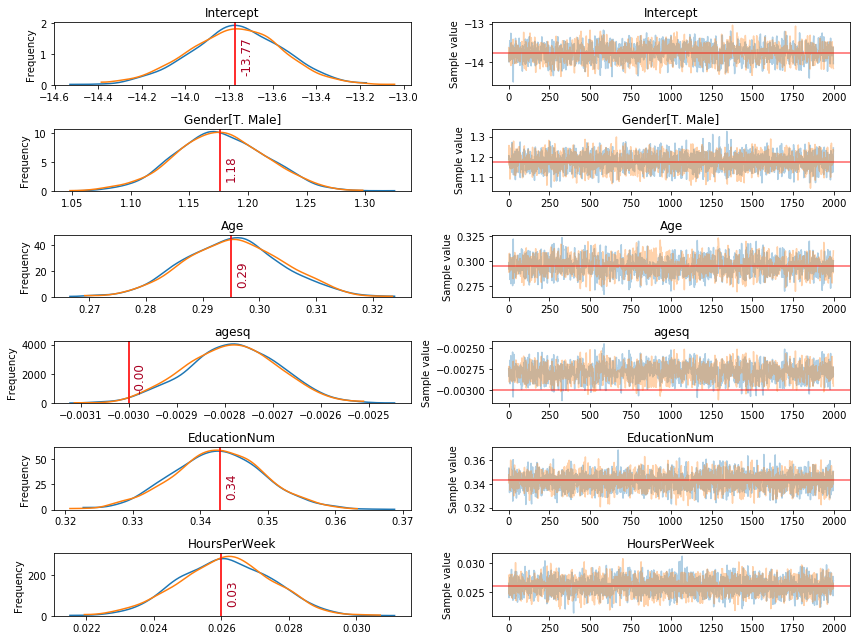

In [16]:
plot_traces(trace)

#### Estimating the odds ratio
The posterior distribution will now be built on the odds ratio given the dataset (approximated by MCMC).

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


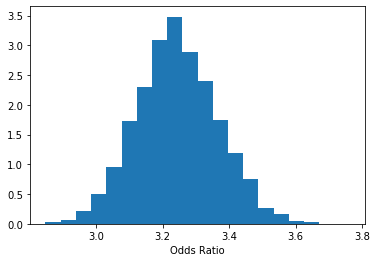

In [17]:
#do not need to use a large burn-in here as sampling initialised from a good point
#(from approximation of the most probable point (MAP))
burnin = 100
b = trace['Gender[T. Male]'][burnin:]
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()


Finally, a credible interval can be found (credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. These credibility intervals enable 95% confidence that the odds ratio lies within the interval.

In [18]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(3.012 < Odds Ratio < 3.485) = 0.95


This interval states that with probability 0.95 the odds ratio is greater than 3.008 and less than 3.498, and so discrimination clearly takes place as a male has at least 3.008 higher probability to get >$50k than a female with the same level of education, age, etc.

## Generating videos of the sampling process

The code below is based on [MCMC visualization tutorial](https://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/), and sets up the plotting functions.

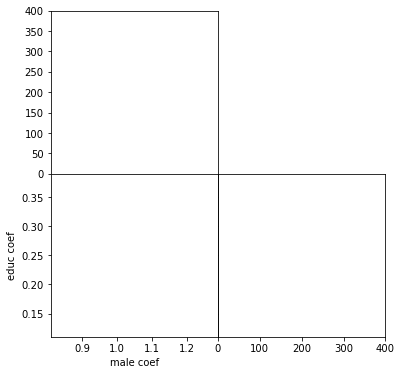

In [19]:
from IPython.display import HTML

#number of MCMC iteration to animate
samples = 400

figsize(6, 6)
fig = plt.figure()
s_width = (0.81, 1.29)
a_width = (0.11, 0.39)
samples_width = (0, samples)
ax1 = fig.add_subplot(221, xlim=s_width, ylim=samples_width)
ax2 = fig.add_subplot(224, xlim=samples_width, ylim=a_width)
ax3 = fig.add_subplot(223, xlim=s_width, ylim=a_width,
                      xlabel='male coef',
                      ylabel='educ coef')
fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    with logistic_model:
        if i == 0:
            #burnin
            for j in range(samples): iter_sample.__next__() 
        trace = iter_sample.__next__()
    line1.set_data(trace['Gender[T. Male]'][::-1], range(len(trace['Gender[T. Male]'])))
    line2.set_data(range(len(trace['EducationNum'])), trace['EducationNum'][::-1])
    line3.set_data(trace['Gender[T. Male]'], trace['EducationNum'])
    line4.set_data(trace['Gender[T. Male]'], trace['EducationNum'])
    male = trace['Gender[T. Male]'][-1]
    educ = trace['EducationNum'][-1]
    line5.set_data([male, male], [educ, a_width[1]])
    line6.set_data([male, s_width[1]], [educ, educ])
    return lines

### Animating Metropolis-Hastings

In [20]:
with pm.Model() as logistic_model:
    #define Bayesian logistic regression model on features
    pm.glm.GLM.from_formula('Income ~ Gender + Age + agesq + EducationNum + HoursPerWeek', data, family=pm.glm.families.Binomial())    
    step = pm.Metropolis()
    iter_sample = pm.iter_sample(2 * samples, step, start=map_estimate)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples, interval=5, blit=True)
HTML(anim.to_html5_video())

### Animating NUTS
Now rerun the animation providing the NUTS sampling method as the step argument.

In [21]:
with pm.Model() as logistic_model:
    
    pm.glm.GLM.from_formula('Income ~ Gender + Age + agesq + EducationNum + HoursPerWeek', data, family=pm.glm.families.Binomial())
    iter_sample = pm.iter_sample(2* samples, step=pm.NUTS(), start=map_estimate)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples, interval=5, blit=True)
HTML(anim.to_html5_video())